# Model-Based RL
In this exercise you will implement a policy and model network which work in tandem to solve the CartPole reinforcement learning problem.

What is a model and why would we want to use one? In this case, a model is going to be a neural network that attempts to learn the dynamics of the real environment. For example, in the CartPole we would like a model to be able to predict the next position of the Cart given the previous position and an action. By learning an accurate model, we can train our agent using the model rather than requiring to use the real environment every time. While this may seem less useful when the real environment is itself a simulation, like in our CartPole task, it can have huge advantages when attempting to learn policies for acting in the physical world.

How are we going to accomplish this in Tensorflow? We are going to be using a neural network that will learn the transition dynamics between a previous observation and action, and the expected new observation, reward, and done state. Our training procedure will involve switching between training our model using the real environment, and training our agent’s policy using the model environment. By using this approach we will be able to learn a policy that allows our agent to solve the CartPole task without actually ever training the policy on the real environment! 

### Loading libraries and starting CartPole environment

In [1]:
from __future__ import print_function
import numpy as np
try:
    import cPickle as pickle
except:
    import pickle
import tensorflow as tf
%matplotlib inline
import matplotlib.pyplot as plt
import math

In [2]:
import sys
if sys.version_info.major > 2:
    xrange = range
del sys

In [3]:
import gym
env = gym.make('CartPole-v0')

### Setting Hyper-parameters

In [4]:
# Hyperparameters
H = 8 # number of Hidden layer neurons
learning_rate = 1e-2
gamma = 0.99 # Discount factor for reward
decay_rate = 0.99 # Decay factor for RMSProp leaky sum of grad^2
resume = False # Resume from previous checkpoint?

model_bs = 3 # Batch size when learning from model
real_bs = 3 # Batch size when learning from real environment

# Nodel initialization
D = 4 # Input dimensionality

### Policy Network

In [5]:
tf.reset_default_graph()

observations = tf.placeholder(tf.float32, [None, 4], name = "input_x")

W1 = tf.get_variable(
    "W1",
    shape = [4, H],
    initializer = tf.contrib.layers.xavier_initializer()
)
layer1 = tf.nn.relu(tf.matmul(observations, W1))

W2 = tf.get_variable(
    "W2",
    shape=[H, 1],
    initializer = tf.contrib.layers.xavier_initializer()
)

score = tf.matmul(layer1, W2)
probability = tf.nn.sigmoid(score)

tvars = tf.trainable_variables()

input_y = tf.placeholder(tf.float32, [None, 1], name = "input_y")
advantages = tf.placeholder(tf.float32, name = "reward_signal")

adam = tf.train.AdamOptimizer(learning_rate = learning_rate)
W1Grad = tf.placeholder(tf.float32, name = "batch_grad1")
W2Grad = tf.placeholder(tf.float32, name = "batch_grad2")
batchGrad = [W1Grad, W2Grad]

################################################################################
# TODO: Implement the loss function.                                           #
# This sends the weights in the direction of making actions that gave good     #
# advantage (reward overtime) more likely, and actions that didn't less likely.#
################################################################################

logLikelihood = tf.log(
    (1 - input_y) * probability
    + input_y * (1 - probability)
)

loss = -tf.reduce_mean(logLikelihood * advantages)

################################################################################
#                                 END OF YOUR CODE                             #
################################################################################

newGrads = tf.gradients(loss, tvars)
updateGrads = adam.apply_gradients(zip(batchGrad, tvars))

### Model Network
Here we implement a multi-layer neural network that predicts the next observation, reward, and done state from a current state and action.

In [6]:
mH = 256 # Model layer size

# input_data = tf.placeholder(tf.float32, [None, 5])  # Redundant ???

with tf.variable_scope("rnnlm"):
    softmax_w = tf.get_variable("softmax_w", [mH, 50])
    softmax_b = tf.get_variable("softmax_b", [50])

previous_state = tf.placeholder(tf.float32, [None, 5], name = "previous_state")

W1M = tf.get_variable(
    "W1M",
    shape = [5, mH],
    initializer = tf.contrib.layers.xavier_initializer()
)
B1M = tf.Variable(tf.zeros([mH]), name = "B1M")

layer1M = tf.nn.relu(tf.matmul(previous_state, W1M) + B1M)

W2M = tf.get_variable(
    "W2M",
    shape = [mH, mH],
    initializer = tf.contrib.layers.xavier_initializer()
)
B2M = tf.Variable(tf.zeros([mH]), name = "B2M")

layer2M = tf.nn.relu(tf.matmul(layer1M, W2M) + B2M)

wO = tf.get_variable(
    "wO",
    shape = [mH, 4],
    initializer = tf.contrib.layers.xavier_initializer()
)

wR = tf.get_variable(
    "wR",
    shape = [mH, 1],
    initializer = tf.contrib.layers.xavier_initializer()
)

wD = tf.get_variable(
    "wD",
    shape = [mH, 1],
    initializer = tf.contrib.layers.xavier_initializer()
)

bO = tf.Variable(tf.zeros([4]), name = "bO")
bR = tf.Variable(tf.zeros([1]), name = "bR")
bD = tf.Variable(tf.ones([1]), name="bD")

predicted_observation = tf.matmul(layer2M, wO, name = "predicted_observation") + bO
predicted_reward = tf.matmul(layer2M, wR, name = "predicted_reward") + bR
predicted_done = tf.sigmoid(tf.matmul(layer2M, wD, name = "predicted_done") + bD)

true_observation = tf.placeholder(tf.float32, [None, 4], name = "true_observation")
true_reward = tf.placeholder(tf.float32, [None, 1], name = "true_reward")
true_done = tf.placeholder(tf.float32, [None, 1], name = "true_done")

predicted_state = tf.concat([predicted_observation, predicted_reward, predicted_done], 1)

observation_loss = tf.square(true_observation - predicted_observation)

reward_loss = tf.square(true_reward - predicted_reward)

done_loss = tf.multiply(predicted_done, true_done) + tf.multiply(1 - predicted_done, 1 - true_done)
done_loss = -tf.log(done_loss)

model_loss = tf.reduce_mean(observation_loss + done_loss + reward_loss)

modelAdam = tf.train.AdamOptimizer(learning_rate = learning_rate)
updateModel = modelAdam.minimize(model_loss)

### Helper-functions

In [7]:
def resetGradBuffer(gradBuffer):
    for ix, grad in enumerate(gradBuffer):
        gradBuffer[ix] = grad * 0
    return gradBuffer



def discount_rewards(r):
    ################################################################################
    # TODO: Implement the discounted rewards function                              #
    # Return discounted rewards weighed by gamma. Each reward will be replaced     #
    # with a weight reward that involves itself and all the other rewards occuring #
    # after it. The later the reward after it happens, the less effect it has on   #
    # the current rewards's discounted reward                                      #
    # Hint: [r0, r1, r2, ..., r_N] will look someting like:                        #
    #       [(r0 + r1*gamma^1 + ... r_N*gamma^N), (r1 + r2*gamma^1 + ...), ...]    #
    ################################################################################

    result = np.zeros_like(r, dtype = np.float32)

    cumm = 0.0        
    for i in xrange(result.shape[0] - 1, -1, -1):
        cumm = cumm * gamma + r[i, 0]
        result[i, 0] = cumm        
    
    return result        
    
    ################################################################################
    #                                 END OF YOUR CODE                             #
    ################################################################################

    
    
# This function uses our model to produce a new state when given a previous state and action
# xs: Set of states
def stepModel(sess, xs, action):
    # Just feed the last state in the set xs
    toFeed = np.reshape(
        np.hstack([xs[-1][0], np.array(action)]),
        [1, 5]
    )
    
    myPredict = sess.run([predicted_state], feed_dict = {previous_state: toFeed})
    
    reward = myPredict[0][:, 4]
    
    observation = myPredict[0][:, 0: 4]
    observation[:, 0] = np.clip(observation[:, 0], -2.4, 2.4)
    observation[:, 2] = np.clip(observation[:, 2], -0.4, 0.4)
    
    doneP = np.clip(myPredict[0][:, 5], 0, 1)
        
    if doneP > 0.1 or len(xs) >= 300:
        done = True
    else:
        done = False
        
    return observation, reward, done

## Training the Policy and Model

In [8]:
xs, drs, ys, ds = [], [], [], []
running_reward = None
reward_sum = 0
episode_number = 1
real_episodes = 1

init = tf.global_variables_initializer()
batch_size = real_bs

drawFromModel = False # When set to True, will use model for observations
trainTheModel = True # Whether to train the model

trainThePolicy = False # Whether to train the policy

switch_point = 1

# Launch the graph
with tf.Session() as sess:
    rendering = False
    
    sess.run(init)
    
    observation = env.reset()
    x = observation
    
    gradBuffer = sess.run(tvars)
    gradBuffer = resetGradBuffer(gradBuffer)
    
    while episode_number <= 5000:
        # Start displaying environment once performance is acceptably high.
        if (reward_sum / batch_size > 150 and drawFromModel == False) or rendering == True: 
            # env.render()
            rendering = True
            
        x = np.reshape(observation, [1, 4])

        tfprob = sess.run(probability, feed_dict = {observations: x})
        action = 1 if np.random.uniform() < tfprob else 0

        # Record various intermediates (needed later for backprop)
        xs.append(x)
        
        y = 1 if action == 0 else 0    # "Fake" label
        ys.append(y)
        
        # Step the  model or real environment and get new measurements
        if drawFromModel == False:
            observation, reward, done, info = env.step(action)
        else:
            observation, reward, done = stepModel(sess, xs, action)
                
        reward_sum += reward
        
        ds.append(done * 1)
        
        # Record reward (has to be done after we call step() to get reward for previous action)
        drs.append(reward) 

        if done:
            episode_number += 1
            
            if drawFromModel == False: 
                real_episodes += 1

            # Stack together all inputs, hidden states, action gradients, and rewards for this episode
            epx = np.vstack(xs)
            epy = np.vstack(ys)
            epr = np.vstack(drs)
            epd = np.vstack(ds)
            
            xs, drs, ys, ds = [], [], [], [] # Reset array memory
            
            if trainTheModel == True:                
                ################################################################################
                # TODO: Run the model network and compute predicted_state                      #
                # Output: 'pState'                                                             #
                ################################################################################
                
                state_nextsAll = np.hstack([epx, epr, epd])
                
                # Note: action & y is ALWAYS opposite
                epXandAction = np.hstack([epx, 1 - epy])
                
                pState, _ = sess.run([predicted_state, updateModel], feed_dict = {
                    previous_state: epXandAction[: -1],
                    true_observation: epx[1: ],
                    true_reward: epr[1: ],
                    true_done: epd[1: ]
                })
                
                ################################################################################
                #                                 END OF YOUR CODE                             #
                ################################################################################                

            if trainThePolicy == True:
                
                ################################################################################
                # TODO: Run the policy network and compute newGrads                            #
                # Output: 'tGrad'                                                              #
                ################################################################################
                
                discounted_epr = discount_rewards(epr)
                discounted_epr -= np.mean(discounted_epr)
                discounted_epr /= np.std(discounted_epr)
                
                tGrad = sess.run(newGrads, feed_dict = {
                    observations: epx,
                    input_y: epy,
                    advantages: discounted_epr
                })
                
                ################################################################################
                #                                 END OF YOUR CODE                             #
                ################################################################################
                
                # If gradients becom too large, end training process
                if np.sum(tGrad[0] == tGrad[0]) == 0:
                    break
                    
                for ix, grad in enumerate(tGrad):
                    gradBuffer[ix] += grad
                
            if switch_point + batch_size == episode_number:
                switch_point = episode_number
                
                if trainThePolicy == True:
                    
                    ################################################################################
                    # TODO:                                                                        #
                    # (1) Run the policy network and update gradients                              #
                    # (2) Reset gradBuffer to 0                                                    #
                    ################################################################################
                    
                    sess.run(updateGrads, feed_dict = {
                        W1Grad: gradBuffer[0],
                        W2Grad: gradBuffer[1]
                    })
                    
                    gradBuffer = resetGradBuffer(gradBuffer)
                    
                    ################################################################################
                    #                                 END OF YOUR CODE                             #
                    ################################################################################

                running_reward = reward_sum if running_reward is None else (running_reward * 0.99 + reward_sum * 0.01)
                
                if drawFromModel == False:
                    print("World Perf: Episode %d. Reward %f. action: %f. mean reward %f." % (
                        real_episodes,
                        reward_sum / real_bs,
                        action,
                        running_reward / real_bs
                    ))
                    
                    if reward_sum / batch_size > 200:
                        break
                        
                reward_sum = 0

                # Once the model has been trained on 100 episodes
                if episode_number > 100:
                    
                    ################################################################################
                    # TODO: Alternating between training the policy from the model and training    #
                    # the model from the real environment.                                         #
                    ################################################################################                 
                    
                    drawFromModel = not drawFromModel
                    trainTheModel = not trainTheModel
                    
                    trainThePolicy = not trainThePolicy                    
                    
                    ################################################################################
                    #                                 END OF YOUR CODE                             #
                    ################################################################################
            
            if drawFromModel == True:
                observation = np.random.uniform(-0.1, 0.1, [4]) # Generate reasonable starting point
                batch_size = model_bs
            else:
                observation = env.reset()
                batch_size = real_bs
                
print(real_episodes)

World Perf: Episode 4. Reward 31.666667. action: 1.000000. mean reward 31.666667.
World Perf: Episode 7. Reward 34.000000. action: 0.000000. mean reward 31.690000.
World Perf: Episode 10. Reward 18.000000. action: 1.000000. mean reward 31.553100.
World Perf: Episode 13. Reward 29.333333. action: 1.000000. mean reward 31.530902.
World Perf: Episode 16. Reward 20.000000. action: 1.000000. mean reward 31.415593.
World Perf: Episode 19. Reward 16.000000. action: 0.000000. mean reward 31.261437.
World Perf: Episode 22. Reward 25.666667. action: 1.000000. mean reward 31.205490.
World Perf: Episode 25. Reward 19.666667. action: 0.000000. mean reward 31.090101.
World Perf: Episode 28. Reward 27.666667. action: 0.000000. mean reward 31.055867.
World Perf: Episode 31. Reward 23.000000. action: 0.000000. mean reward 30.975308.
World Perf: Episode 34. Reward 21.666667. action: 1.000000. mean reward 30.882222.
World Perf: Episode 37. Reward 14.666667. action: 1.000000. mean reward 30.720066.
World 

World Perf: Episode 301. Reward 54.666667. action: 1.000000. mean reward 43.076687.
World Perf: Episode 304. Reward 72.333333. action: 0.000000. mean reward 43.014236.
World Perf: Episode 307. Reward 62.666667. action: 0.000000. mean reward 42.990295.
World Perf: Episode 310. Reward 39.666667. action: 1.000000. mean reward 44.653408.
World Perf: Episode 313. Reward 50.000000. action: 1.000000. mean reward 44.375065.
World Perf: Episode 316. Reward 75.000000. action: 0.000000. mean reward 44.991924.
World Perf: Episode 319. Reward 48.333333. action: 0.000000. mean reward 44.735355.
World Perf: Episode 322. Reward 52.333333. action: 1.000000. mean reward 44.515858.
World Perf: Episode 325. Reward 50.666667. action: 1.000000. mean reward 44.390537.
World Perf: Episode 328. Reward 60.000000. action: 0.000000. mean reward 44.745102.
World Perf: Episode 331. Reward 58.000000. action: 0.000000. mean reward 44.765472.
World Perf: Episode 334. Reward 50.000000. action: 0.000000. mean reward 46.

World Perf: Episode 607. Reward 39.666667. action: 1.000000. mean reward 41.736656.
World Perf: Episode 610. Reward 69.000000. action: 1.000000. mean reward 41.793736.
World Perf: Episode 613. Reward 70.000000. action: 0.000000. mean reward 41.929470.
World Perf: Episode 616. Reward 71.666667. action: 0.000000. mean reward 42.033360.
World Perf: Episode 619. Reward 60.666667. action: 0.000000. mean reward 42.093472.
World Perf: Episode 622. Reward 51.000000. action: 0.000000. mean reward 42.089756.
World Perf: Episode 625. Reward 105.000000. action: 1.000000. mean reward 42.563702.
World Perf: Episode 628. Reward 41.333333. action: 1.000000. mean reward 42.357422.
World Perf: Episode 631. Reward 56.333333. action: 0.000000. mean reward 42.617428.
World Perf: Episode 634. Reward 56.000000. action: 1.000000. mean reward 42.569569.
World Perf: Episode 637. Reward 54.333333. action: 1.000000. mean reward 42.417782.
World Perf: Episode 640. Reward 40.333333. action: 0.000000. mean reward 44

World Perf: Episode 901. Reward 66.000000. action: 0.000000. mean reward 77.290962.
World Perf: Episode 904. Reward 63.333333. action: 0.000000. mean reward 76.687996.
World Perf: Episode 907. Reward 60.333333. action: 1.000000. mean reward 75.859123.
World Perf: Episode 910. Reward 57.333333. action: 1.000000. mean reward 75.016258.
World Perf: Episode 913. Reward 92.000000. action: 0.000000. mean reward 74.670830.
World Perf: Episode 916. Reward 56.000000. action: 0.000000. mean reward 73.862526.
World Perf: Episode 919. Reward 71.333333. action: 0.000000. mean reward 73.474365.
World Perf: Episode 922. Reward 97.000000. action: 0.000000. mean reward 73.190071.
World Perf: Episode 925. Reward 97.333333. action: 0.000000. mean reward 75.986618.
World Perf: Episode 928. Reward 100.666667. action: 1.000000. mean reward 78.745537.
World Perf: Episode 931. Reward 63.333333. action: 0.000000. mean reward 78.202423.
World Perf: Episode 934. Reward 139.333333. action: 0.000000. mean reward 8

World Perf: Episode 1189. Reward 195.666667. action: 1.000000. mean reward 142.531845.
World Perf: Episode 1192. Reward 164.666667. action: 1.000000. mean reward 142.124664.
World Perf: Episode 1195. Reward 190.666667. action: 0.000000. mean reward 141.911636.
World Perf: Episode 1198. Reward 189.333333. action: 0.000000. mean reward 141.121933.
World Perf: Episode 1201. Reward 200.000000. action: 1.000000. mean reward 143.248871.
World Perf: Episode 1204. Reward 200.000000. action: 1.000000. mean reward 145.374939.
World Perf: Episode 1207. Reward 188.666667. action: 1.000000. mean reward 147.454697.
World Perf: Episode 1210. Reward 198.666667. action: 1.000000. mean reward 149.601074.
World Perf: Episode 1213. Reward 184.000000. action: 0.000000. mean reward 150.450394.
World Perf: Episode 1216. Reward 179.333333. action: 0.000000. mean reward 152.380386.
World Perf: Episode 1219. Reward 200.000000. action: 0.000000. mean reward 152.600021.
World Perf: Episode 1222. Reward 194.333333

World Perf: Episode 1474. Reward 200.000000. action: 1.000000. mean reward 204.104980.
World Perf: Episode 1477. Reward 200.000000. action: 1.000000. mean reward 204.976135.
World Perf: Episode 1480. Reward 200.000000. action: 0.000000. mean reward 205.820480.
World Perf: Episode 1483. Reward 200.000000. action: 0.000000. mean reward 206.673416.
World Perf: Episode 1486. Reward 200.000000. action: 0.000000. mean reward 207.482773.
World Perf: Episode 1489. Reward 200.000000. action: 1.000000. mean reward 208.373215.
World Perf: Episode 1492. Reward 200.000000. action: 1.000000. mean reward 207.741409.
World Perf: Episode 1495. Reward 200.000000. action: 0.000000. mean reward 208.513565.
World Perf: Episode 1498. Reward 200.000000. action: 1.000000. mean reward 209.299515.
World Perf: Episode 1501. Reward 200.000000. action: 1.000000. mean reward 209.000534.
World Perf: Episode 1504. Reward 200.000000. action: 0.000000. mean reward 209.742966.
World Perf: Episode 1507. Reward 200.000000

World Perf: Episode 1759. Reward 200.000000. action: 1.000000. mean reward 236.503983.
World Perf: Episode 1762. Reward 200.000000. action: 0.000000. mean reward 236.780777.
World Perf: Episode 1765. Reward 179.333333. action: 1.000000. mean reward 236.893326.
World Perf: Episode 1768. Reward 200.000000. action: 1.000000. mean reward 237.150284.
World Perf: Episode 1771. Reward 200.000000. action: 0.000000. mean reward 236.651367.
World Perf: Episode 1774. Reward 192.000000. action: 0.000000. mean reward 236.772751.
World Perf: Episode 1777. Reward 200.000000. action: 1.000000. mean reward 234.799240.
World Perf: Episode 1780. Reward 200.000000. action: 1.000000. mean reward 235.082504.
World Perf: Episode 1783. Reward 200.000000. action: 1.000000. mean reward 235.337326.
World Perf: Episode 1786. Reward 200.000000. action: 0.000000. mean reward 234.779007.
World Perf: Episode 1789. Reward 200.000000. action: 1.000000. mean reward 234.994202.
World Perf: Episode 1792. Reward 200.000000

World Perf: Episode 2044. Reward 196.666667. action: 1.000000. mean reward 239.475388.
World Perf: Episode 2047. Reward 183.333333. action: 0.000000. mean reward 239.466202.
World Perf: Episode 2050. Reward 200.000000. action: 1.000000. mean reward 240.041077.
World Perf: Episode 2053. Reward 200.000000. action: 0.000000. mean reward 240.162247.
World Perf: Episode 2056. Reward 200.000000. action: 1.000000. mean reward 241.140137.
World Perf: Episode 2059. Reward 200.000000. action: 1.000000. mean reward 238.458572.
World Perf: Episode 2062. Reward 200.000000. action: 1.000000. mean reward 238.630325.
World Perf: Episode 2065. Reward 188.666667. action: 0.000000. mean reward 238.627808.
World Perf: Episode 2068. Reward 200.000000. action: 1.000000. mean reward 240.080261.
World Perf: Episode 2071. Reward 200.000000. action: 1.000000. mean reward 237.997055.
World Perf: Episode 2074. Reward 200.000000. action: 0.000000. mean reward 238.051758.
World Perf: Episode 2077. Reward 200.000000

World Perf: Episode 2329. Reward 200.000000. action: 1.000000. mean reward 236.911331.
World Perf: Episode 2332. Reward 200.000000. action: 1.000000. mean reward 237.722427.
World Perf: Episode 2335. Reward 200.000000. action: 1.000000. mean reward 237.784851.
World Perf: Episode 2338. Reward 200.000000. action: 1.000000. mean reward 238.144669.
World Perf: Episode 2341. Reward 200.000000. action: 0.000000. mean reward 238.471985.
World Perf: Episode 2344. Reward 200.000000. action: 1.000000. mean reward 238.691727.
World Perf: Episode 2347. Reward 200.000000. action: 0.000000. mean reward 238.913010.
World Perf: Episode 2350. Reward 200.000000. action: 1.000000. mean reward 239.085678.
World Perf: Episode 2353. Reward 200.000000. action: 1.000000. mean reward 239.352112.
World Perf: Episode 2356. Reward 200.000000. action: 0.000000. mean reward 237.210953.
World Perf: Episode 2359. Reward 200.000000. action: 0.000000. mean reward 237.837830.
World Perf: Episode 2362. Reward 200.000000

### Checking model representation
Here we can examine how well the model is able to approximate the true environment after training. The green line indicates the real environment, and the blue indicates model predictions.

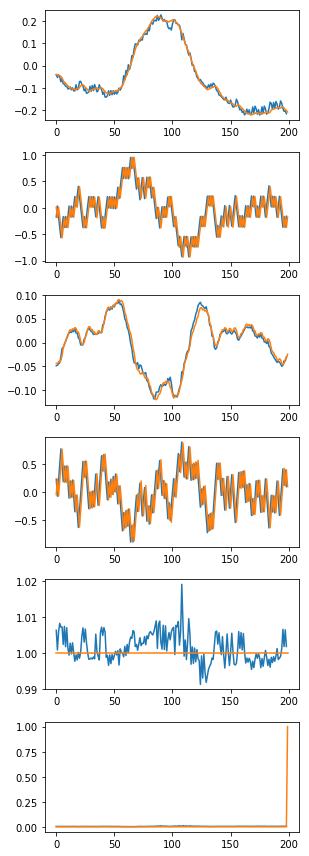

In [9]:
plt.figure(figsize = (8, 12))

for i in range(6):
    plt.subplot(6, 2, 2 * i + 1)
    plt.plot(pState[:, i])
    plt.subplot(6, 2, 2 * i + 1)
    plt.plot(state_nextsAll[:, i])
    
plt.tight_layout()